# Homework 5
## Improving pipeline Homework 3
Machine Learning for Public Policy

Camilo Arias

- load, clean and transform functions in pipeline.py

- classifiers in classifiers.pys

## Improvements

- Feature generation after split
- Includes Bagging
- Calculares precision and recall for top-k% and not for absolute threshold. The same for the plots.
- Uses one function called run_model to build any classifier
- Runs every classifier with different parameters

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pipeline as ppln
import classifiers as classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

### Initial parameters of the program

In [3]:
params = {
    'days': 60,
    'test_size': 0.3,
    'work_with_sample': 0.1,
    'seed': 1234,
    'n_bins': 4,
    'threshold': [0.01, 0.05, 0.1, 0.2, 0.3],
    'id_columns': ['projectid', 'teacher_acctid', 'schoolid'],
    'model_params': {
    'KNN': {'k': [5, 10],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']},
    'decision_tree': {'criterion': ['gini', 'entropy'],
                      'max_depth': [10, 15, 20, 25, 30, 35, 40]},

    'logistic_reg': {'C': [10**-2, 10**-1, 1 , 10, 10**2],
                     'penalty': ['l1', 'l2'],
                     'fit_intercept': [True, False]},

    'svm': {'C': [10**-2, 10**-1, 1 , 10, 10**2]},

    'random_forest': {'criterion': ['gini', 'entropy'],
                      'max_depth': [5, 10, 15],
                      'n_estimators': [80, 90, 100, 150]},

    'gradient_boost': {'max_depth': [5, 10, 15],
                       'n_estimators': [80, 90, 100, 150],
                       'loss': ['deviance', 'exponential']},
    'bagging': {'base_estimator': [None],
                'n_estimators': [80, 90, 100, 150]}}
}
outcome_var = "not_funded_in_{}_days".format(params['days'])

## Create all possible combinations of classifiers and specifications according to the params

In [6]:
models = ppln.get_all_combinations(params['model_params'])

### Load data and see descriptive statistics

In [17]:
projects_df = ppln.load_from_csv('projects_2012_2013.csv')
projects_df = ppln.create_outcome_var(projects_df, params['days'])
projects_gdf = ppln.convert_to_geopandas(projects_df)
us_gdf = ppln.load_us_map('us_shapefile/states.shp')

In [19]:
projects_df[outcome_var].value_counts() / len(projects_df)

0    0.711865
1    0.288135
Name: not_funded_in_60_days, dtype: float64

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 432x288 with 0 Axes>

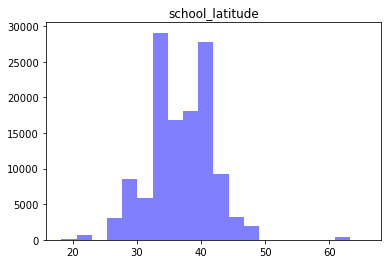

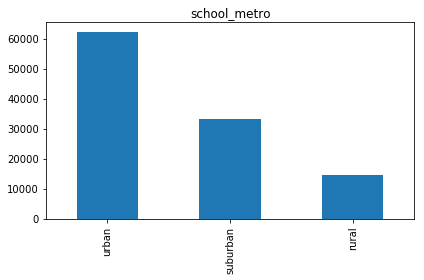

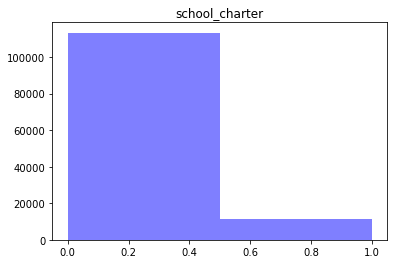

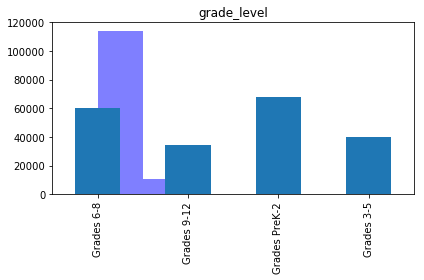

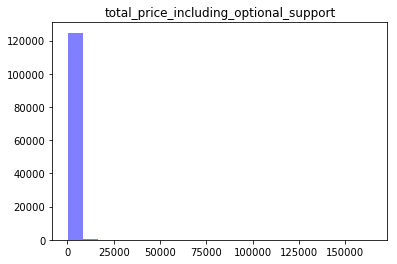

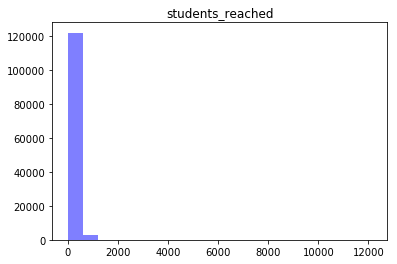

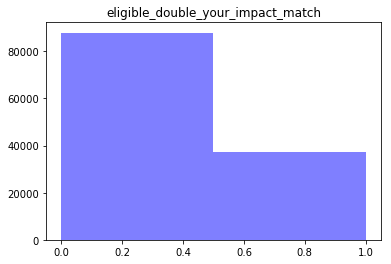

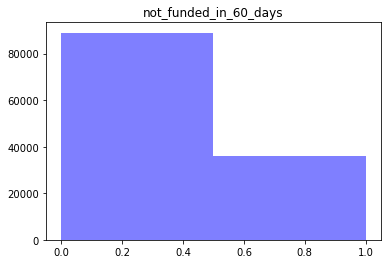

In [20]:
ppln.see_histograms(projects_df)

In [21]:
ppln.summary_by_var(projects_df, outcome_var)

not_funded_in_60_days,0,1,perc diff
school_latitude,37.028738,36.329573,-1.888167
school_longitude,-95.823519,-95.947698,0.129591
school_charter,0.096183,0.085504,-11.102592
school_magnet,0.088652,0.078200,-11.789202
total_price_including_optional_support,594.285067,801.572199,34.880084
students_reached,94.167317,98.604640,4.712169
eligible_double_your_impact_match,0.325709,0.225271,-30.836739


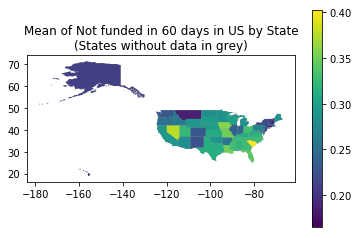

In [22]:
ppln.map_projects(projects_gdf, us_gdf, outcome_var)

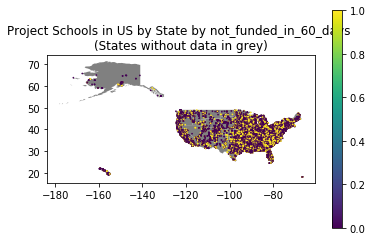

In [23]:
ppln.map_projects(projects_gdf, us_gdf, outcome_var, dense=False)

### Working only with a sample

In [24]:
if params['work_with_sample']:
    projects_df = projects_df.sample(frac=params['work_with_sample'],
                                     random_state=params['seed'])

### Setting Y and X

In [26]:
y = projects_df[outcome_var]
x = projects_df.drop(outcome_var, axis=1)
x = x.drop(params['id_columns'], axis=1)

### Spliting data intro train and test

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=params['test_size'])

## Discretizing and creating dummies
We stay only with the dummies for the prediction

In [28]:
x_train = ppln.discretize(x_train, params['n_bins'])
x_train = ppln.make_dummies_from_categorical(x_train)
x_train = x_train.loc[:,x_train.dtypes == 'uint8']

In [29]:
x_discrete = ppln.discretize(x, params['n_bins'])
x_test = ppln.make_dummies_from_categorical(x_discrete).loc[x_test.index,]
x_test = x_test.loc[:, x_train.columns]

In [30]:
x_train.shape

(8748, 157)

In [31]:
import warnings; warnings.simplefilter('ignore')

# Running models
Each model is run for each of the different possible combinations of specifications speecified in the params dicitonary. Each model score is plotted as well as the precision and recall curves.

##  KNN model with different set of parameters

{'k': 5, 'weights': 'uniform', 'metric': 'euclidean'}


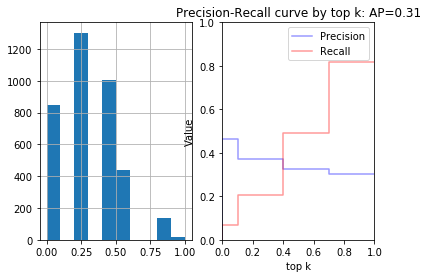

{'k': 5, 'weights': 'uniform', 'metric': 'manhattan'}


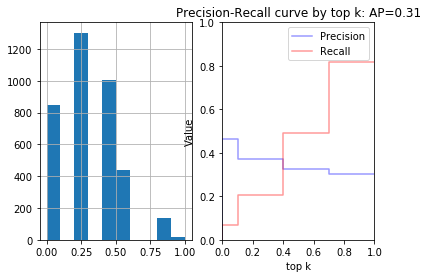

{'k': 5, 'weights': 'uniform', 'metric': 'minkowski'}


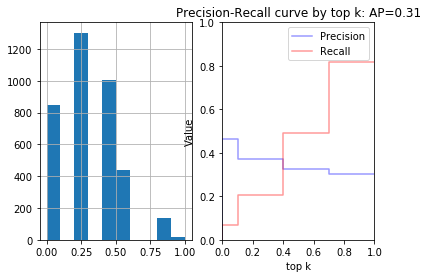

{'k': 5, 'weights': 'distance', 'metric': 'euclidean'}


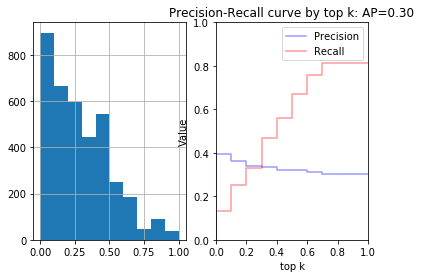

{'k': 5, 'weights': 'distance', 'metric': 'manhattan'}


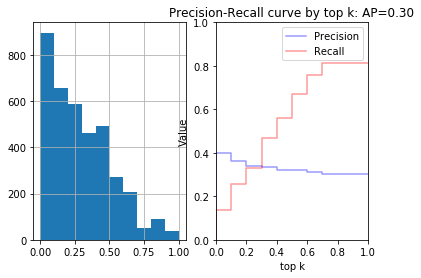

{'k': 5, 'weights': 'distance', 'metric': 'minkowski'}


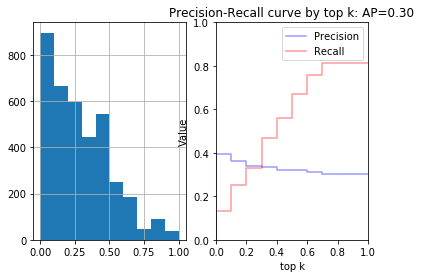

{'k': 10, 'weights': 'uniform', 'metric': 'euclidean'}


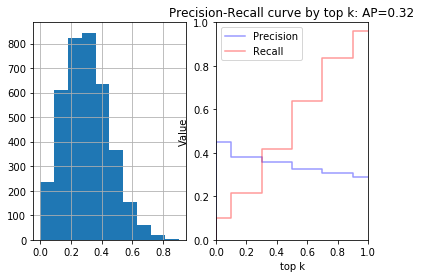

{'k': 10, 'weights': 'uniform', 'metric': 'manhattan'}


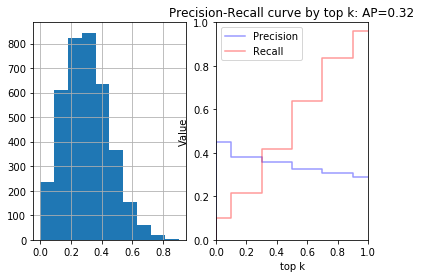

{'k': 10, 'weights': 'uniform', 'metric': 'minkowski'}


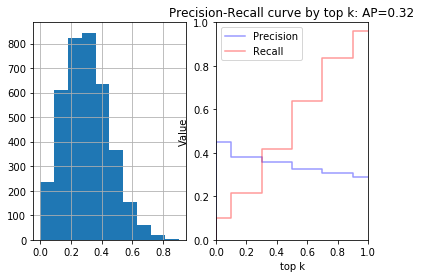

{'k': 10, 'weights': 'distance', 'metric': 'euclidean'}


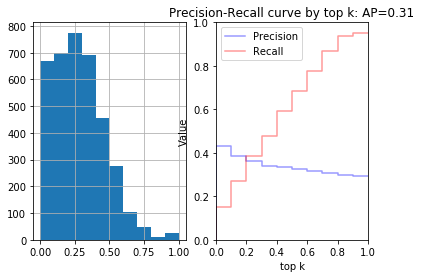

{'k': 10, 'weights': 'distance', 'metric': 'manhattan'}


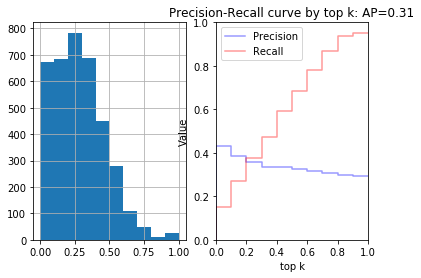

{'k': 10, 'weights': 'distance', 'metric': 'minkowski'}


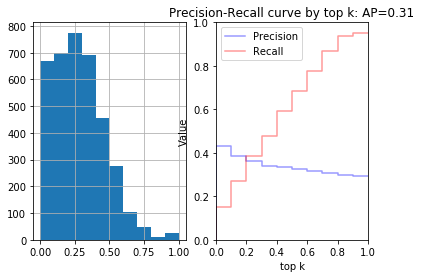

<Figure size 432x288 with 0 Axes>

In [37]:
for specification in models['KNN']:
    print(specification)
    knn_prob = classif.run_model(x_train, y_train, x_test, 'KNN', specification)
    plt.subplot(121)
    knn_prob.hist()
    plt.subplot(122)
    classif.plot_precision_recall(y_test, knn_prob)
    plt.show()
    plt.clf()

##  DT model with different set of parameters

{'criterion': 'gini', 'max_depth': 10}


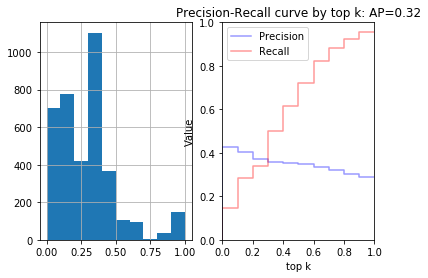

{'criterion': 'gini', 'max_depth': 15}


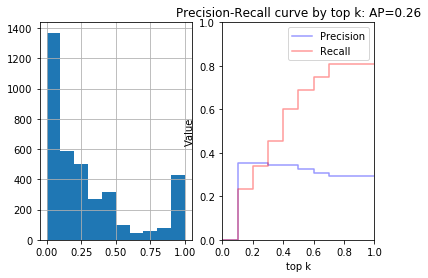

{'criterion': 'gini', 'max_depth': 20}


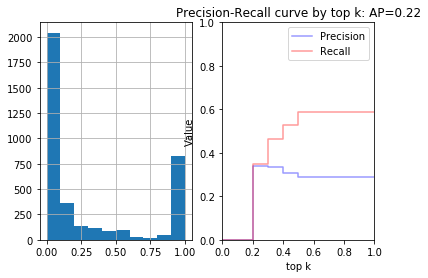

{'criterion': 'gini', 'max_depth': 25}


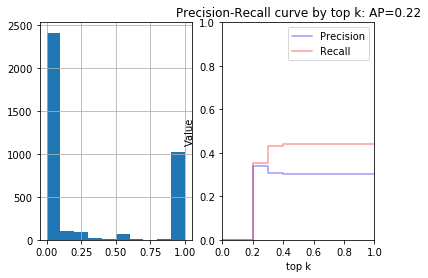

{'criterion': 'gini', 'max_depth': 30}


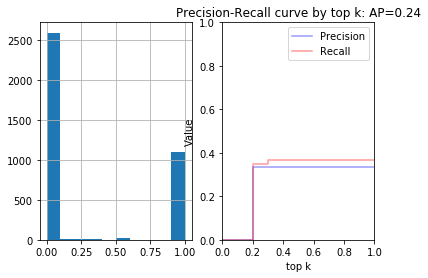

{'criterion': 'gini', 'max_depth': 35}


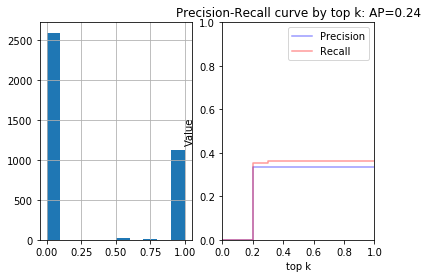

{'criterion': 'gini', 'max_depth': 40}


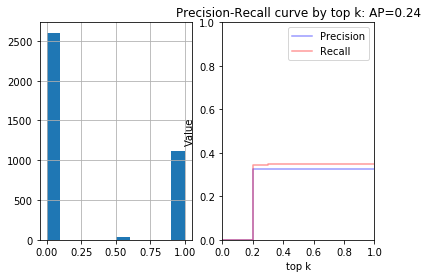

{'criterion': 'entropy', 'max_depth': 10}


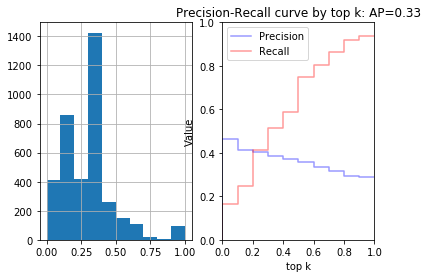

{'criterion': 'entropy', 'max_depth': 15}


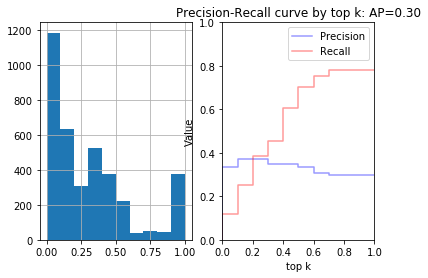

{'criterion': 'entropy', 'max_depth': 20}


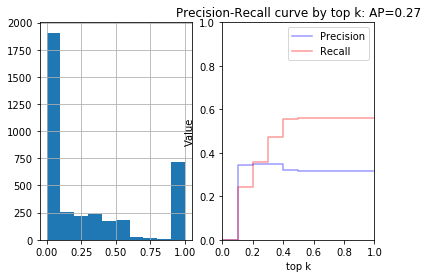

{'criterion': 'entropy', 'max_depth': 25}


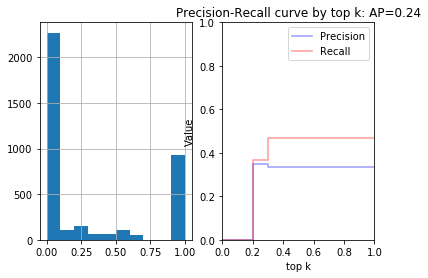

{'criterion': 'entropy', 'max_depth': 30}


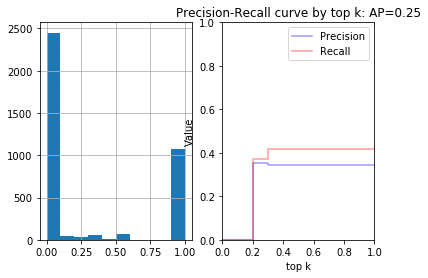

{'criterion': 'entropy', 'max_depth': 35}


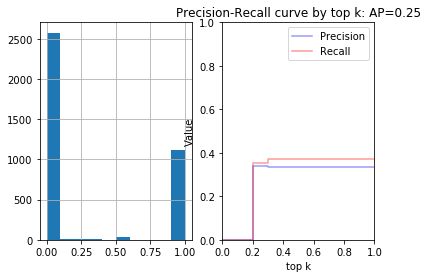

{'criterion': 'entropy', 'max_depth': 40}


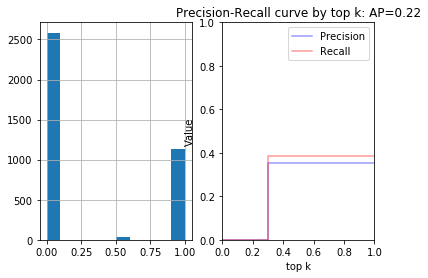

<Figure size 432x288 with 0 Axes>

In [38]:
for specification in models['decision_tree']:
    print(specification)
    dt_prob = classif.run_model(x_train, y_train, x_test, 'decision_tree', specification)
    plt.subplot(121)
    dt_prob.hist()
    plt.subplot(122)
    classif.plot_precision_recall(y_test, dt_prob)
    plt.show()
    plt.clf()

##  Logistic Regression model with different set of parameters

In [ ]:
for specification in models['logistic_reg']:
    specification['seed'] = params['seed']
    print(specification)
    lr_prob = classif.run_model(x_train, y_train, x_test, 'logistic_reg', specification)
    plt.subplot(121)
    lr_prob.hist()
    plt.subplot(122)
    classif.plot_precision_recall(y_test, lr_prob)
    plt.show()
    plt.clf()

##  SVM model with differen set of parameters

{'C': 0.01, 'seed': 1234}


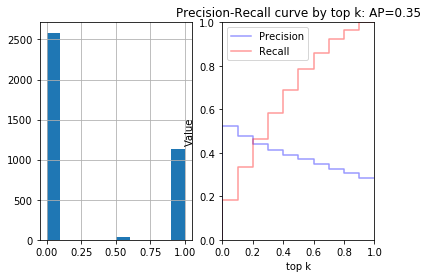

{'C': 0.1, 'seed': 1234}


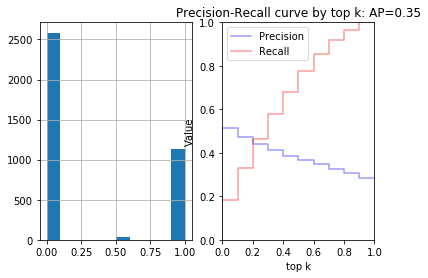

{'C': 1, 'seed': 1234}


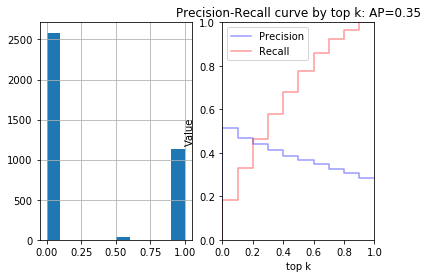

{'C': 10, 'seed': 1234}


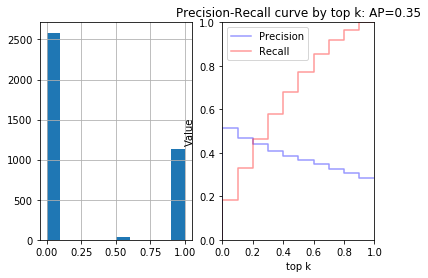

{'C': 100, 'seed': 1234}


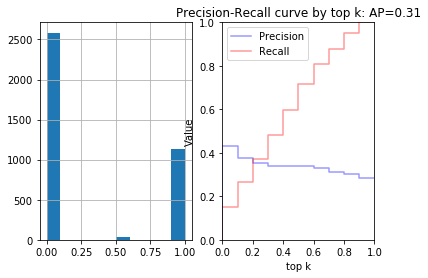

<Figure size 432x288 with 0 Axes>

In [39]:
for specification in models['svm']:
    specification['seed'] = params['seed']
    print(specification)
    svm_prob = classif.run_model(x_train, y_train, x_test, 'svm', specification)
    plt.subplot(121)
    svm_prob.hist()
    plt.subplot(122)
    classif.plot_precision_recall(y_test, svm_prob)
    plt.show()
    plt.clf()

##  Random Forest model with one set of parameters

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80, 'seed': 1234}


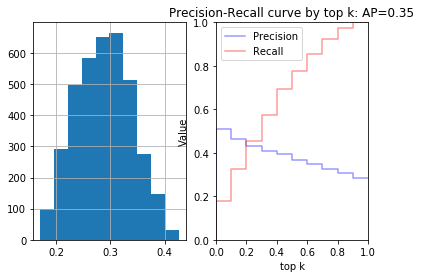

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 90, 'seed': 1234}


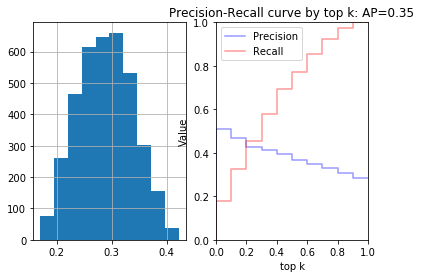

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100, 'seed': 1234}


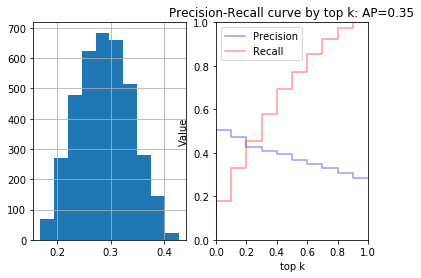

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 150, 'seed': 1234}


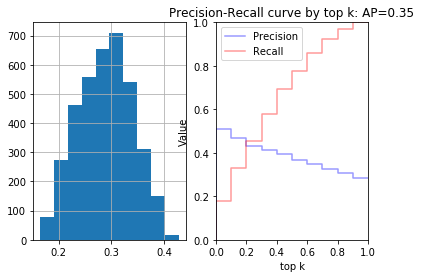

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80, 'seed': 1234}


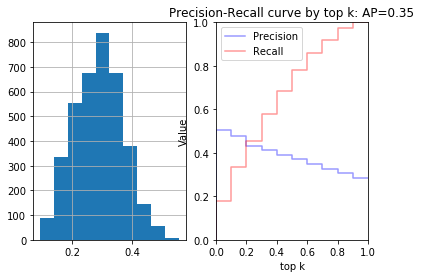

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 90, 'seed': 1234}


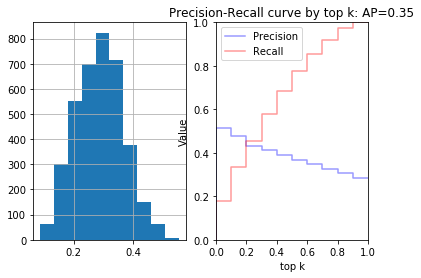

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100, 'seed': 1234}


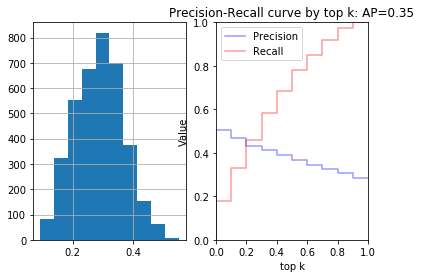

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 150, 'seed': 1234}


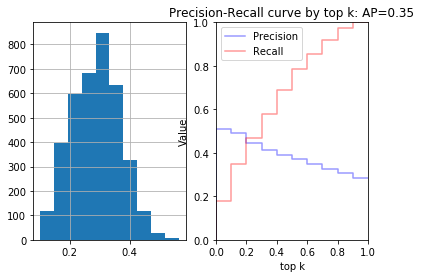

{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 80, 'seed': 1234}


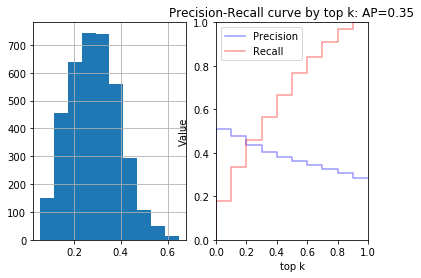

{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 90, 'seed': 1234}


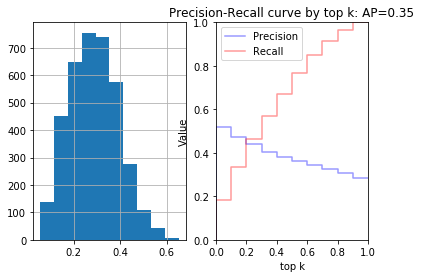

{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 100, 'seed': 1234}


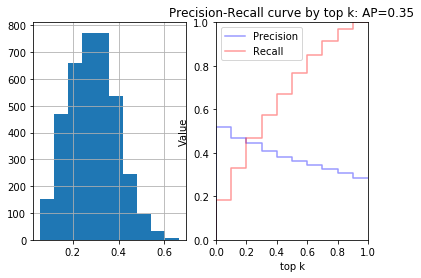

{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 150, 'seed': 1234}


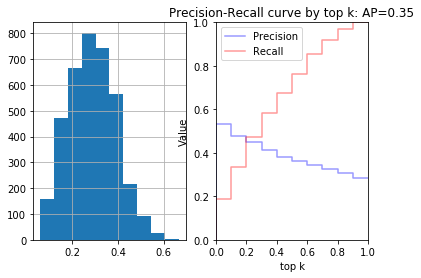

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80, 'seed': 1234}


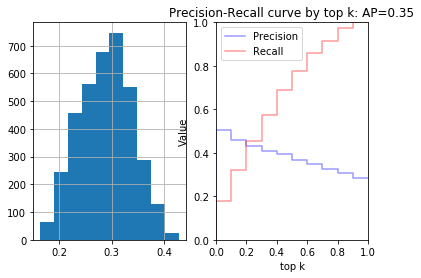

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 90, 'seed': 1234}


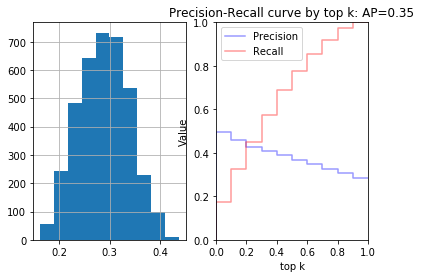

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100, 'seed': 1234}


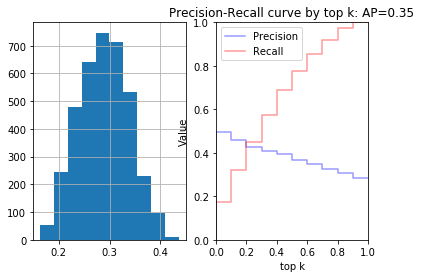

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 150, 'seed': 1234}


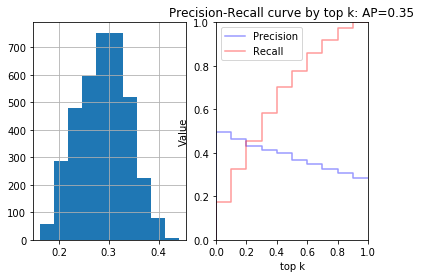

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80, 'seed': 1234}


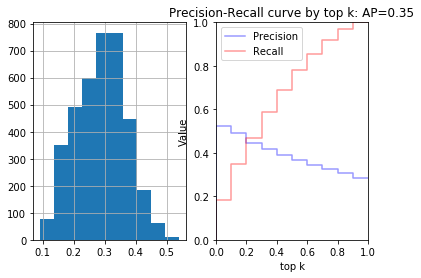

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 90, 'seed': 1234}


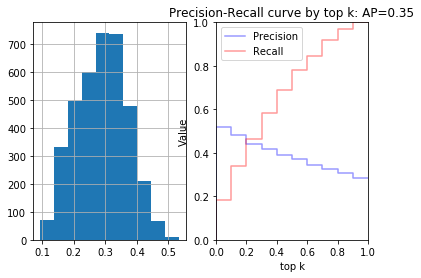

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100, 'seed': 1234}


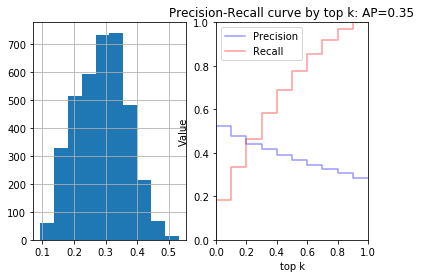

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 150, 'seed': 1234}


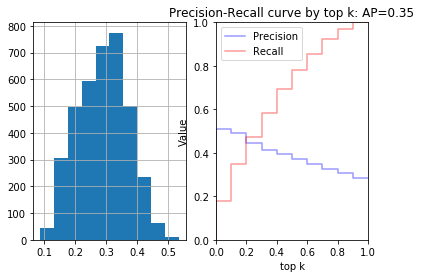

{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 80, 'seed': 1234}


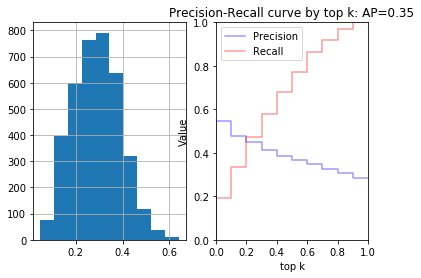

{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 90, 'seed': 1234}


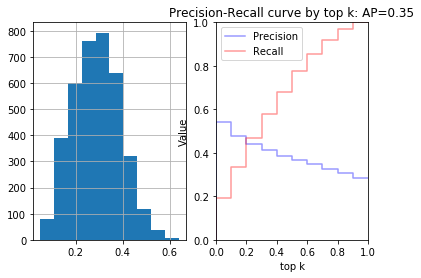

{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 100, 'seed': 1234}


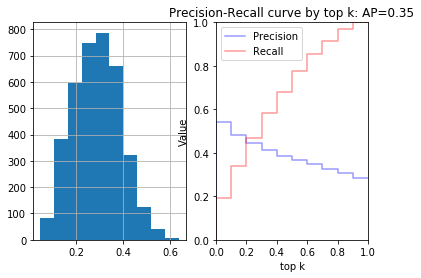

{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 150, 'seed': 1234}


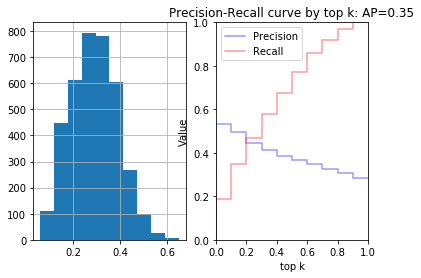

<Figure size 432x288 with 0 Axes>

In [42]:
for specification in models['random_forest']:
    specification['seed'] = params['seed']
    print(specification)
    rf_prob = classif.run_model(x_train, y_train, x_test, 'random_forest', specification)
    plt.subplot(121)
    rf_prob.hist()
    plt.subplot(122)
    classif.plot_precision_recall(y_test, rf_prob)
    plt.show()
    plt.clf()

##  Gradient Boost model with one set of parameters

{'max_depth': 5, 'n_estimators': 80, 'loss': 'deviance', 'seed': 1234}


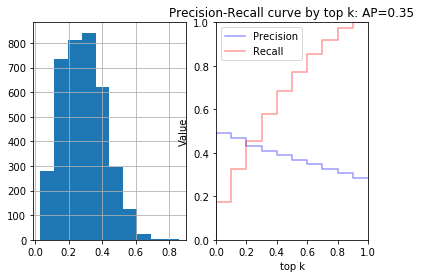

{'max_depth': 5, 'n_estimators': 80, 'loss': 'exponential', 'seed': 1234}


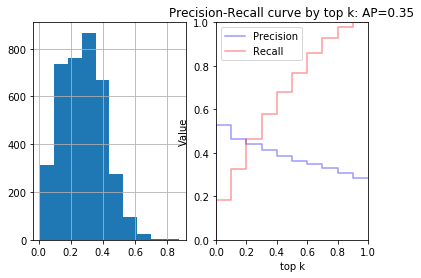

{'max_depth': 5, 'n_estimators': 90, 'loss': 'deviance', 'seed': 1234}


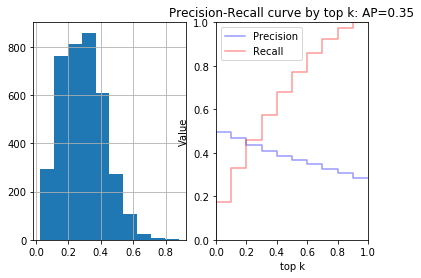

{'max_depth': 5, 'n_estimators': 90, 'loss': 'exponential', 'seed': 1234}


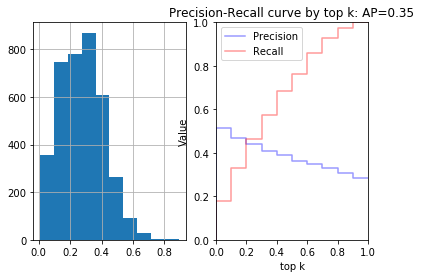

{'max_depth': 5, 'n_estimators': 100, 'loss': 'deviance', 'seed': 1234}


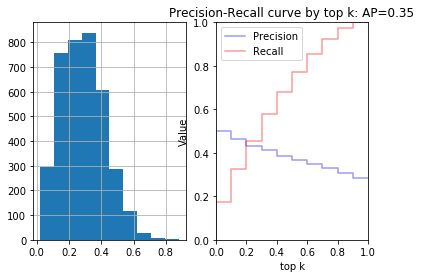

{'max_depth': 5, 'n_estimators': 100, 'loss': 'exponential', 'seed': 1234}


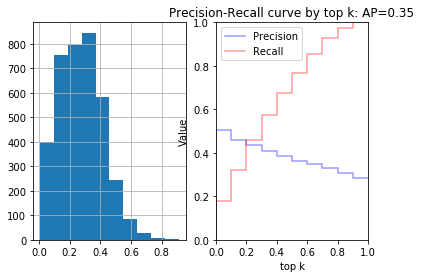

{'max_depth': 5, 'n_estimators': 150, 'loss': 'deviance', 'seed': 1234}


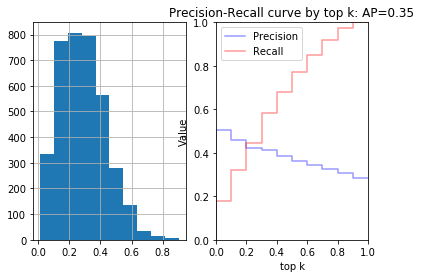

{'max_depth': 5, 'n_estimators': 150, 'loss': 'exponential', 'seed': 1234}


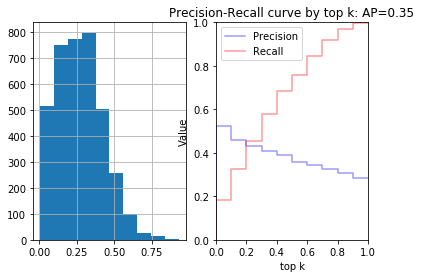

{'max_depth': 10, 'n_estimators': 80, 'loss': 'deviance', 'seed': 1234}


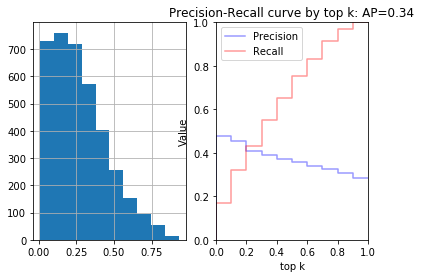

{'max_depth': 10, 'n_estimators': 80, 'loss': 'exponential', 'seed': 1234}


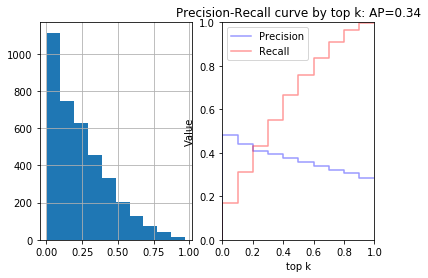

{'max_depth': 10, 'n_estimators': 90, 'loss': 'deviance', 'seed': 1234}


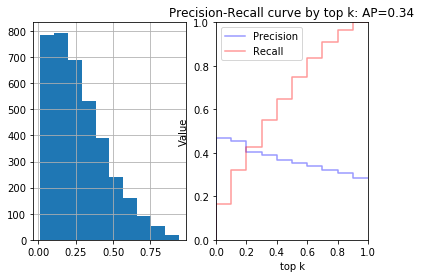

{'max_depth': 10, 'n_estimators': 90, 'loss': 'exponential', 'seed': 1234}


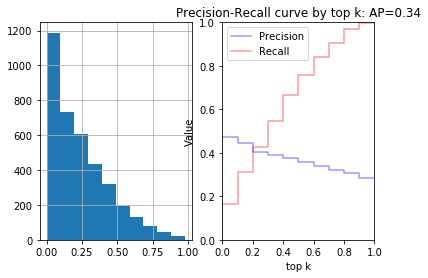

{'max_depth': 10, 'n_estimators': 100, 'loss': 'deviance', 'seed': 1234}


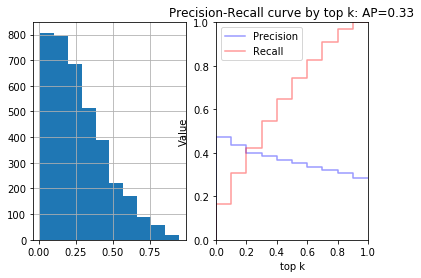

{'max_depth': 10, 'n_estimators': 100, 'loss': 'exponential', 'seed': 1234}


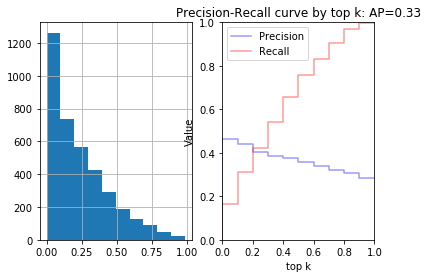

{'max_depth': 10, 'n_estimators': 150, 'loss': 'deviance', 'seed': 1234}


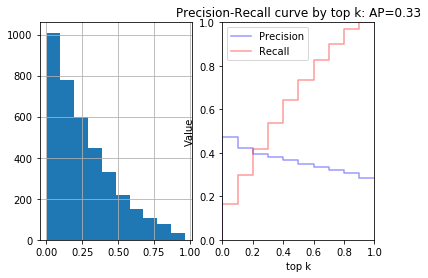

{'max_depth': 10, 'n_estimators': 150, 'loss': 'exponential', 'seed': 1234}


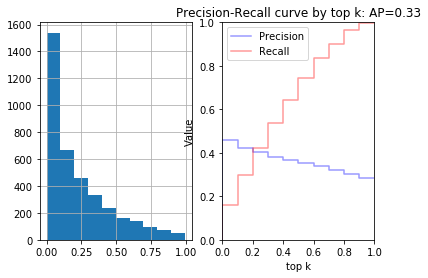

{'max_depth': 15, 'n_estimators': 80, 'loss': 'deviance', 'seed': 1234}


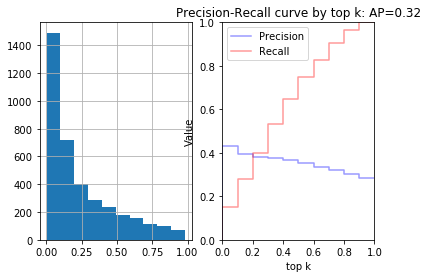

{'max_depth': 15, 'n_estimators': 80, 'loss': 'exponential', 'seed': 1234}


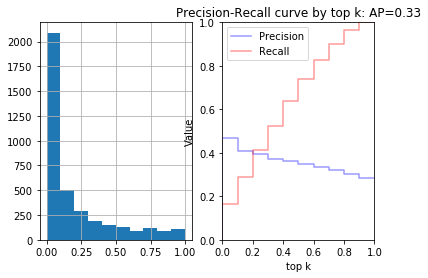

{'max_depth': 15, 'n_estimators': 90, 'loss': 'deviance', 'seed': 1234}


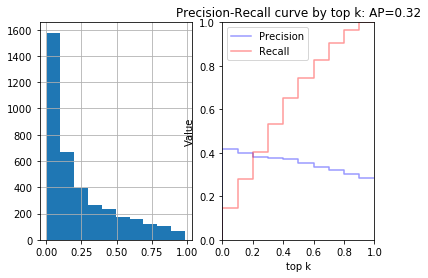

{'max_depth': 15, 'n_estimators': 90, 'loss': 'exponential', 'seed': 1234}


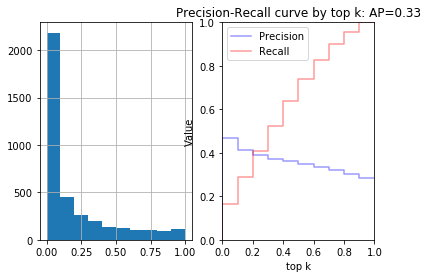

{'max_depth': 15, 'n_estimators': 100, 'loss': 'deviance', 'seed': 1234}


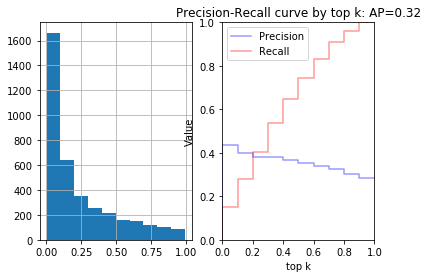

{'max_depth': 15, 'n_estimators': 100, 'loss': 'exponential', 'seed': 1234}


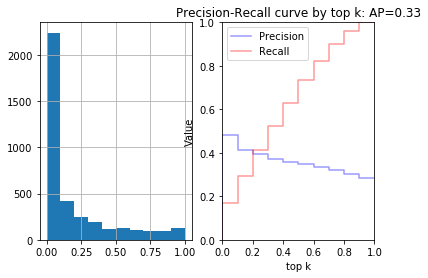

{'max_depth': 15, 'n_estimators': 150, 'loss': 'deviance', 'seed': 1234}


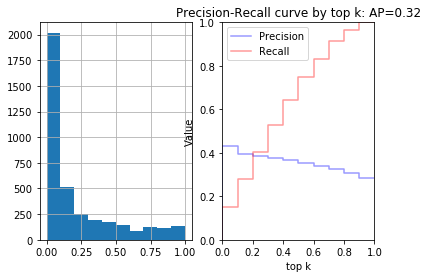

{'max_depth': 15, 'n_estimators': 150, 'loss': 'exponential', 'seed': 1234}


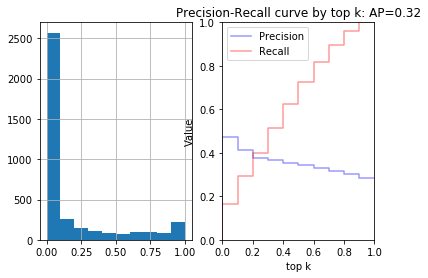

<Figure size 432x288 with 0 Axes>

In [43]:
for specification in models['gradient_boost']:
    specification['seed'] = params['seed']
    print(specification)
    gb_prob = classif.run_model(x_train, y_train, x_test, 'gradient_boost', specification)
    plt.subplot(121)
    gb_prob.hist()
    plt.subplot(122)
    classif.plot_precision_recall(y_test, gb_prob)
    plt.show()
    plt.clf()

##  Bagging model with one set of parameters

{'base_estimator': None, 'n_estimators': 80, 'seed': 1234}


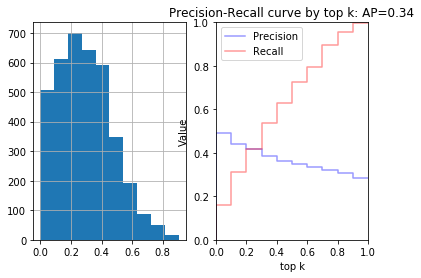

{'base_estimator': None, 'n_estimators': 90, 'seed': 1234}


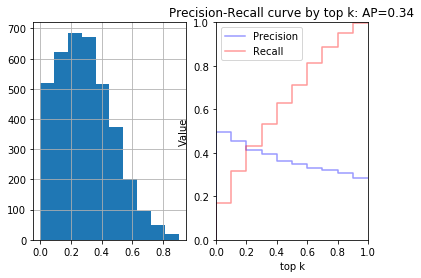

{'base_estimator': None, 'n_estimators': 100, 'seed': 1234}


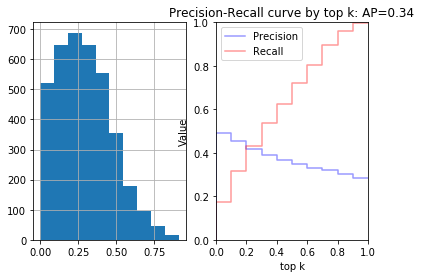

{'base_estimator': None, 'n_estimators': 150, 'seed': 1234}


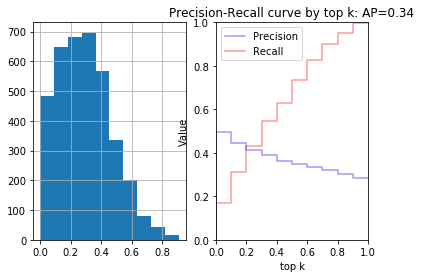

<Figure size 432x288 with 0 Axes>

In [58]:
for specification in models['bagging']:
    specification['seed'] = params['seed']
    print(specification)
    bag_prob = classif.run_model(x_train, y_train, x_test, 'bagging', specification)
    plt.subplot(121)
    bag_prob.hist()
    plt.subplot(122)
    classif.plot_precision_recall(y_test, bag_prob)
    plt.show()
    plt.clf()